# Κατασκευή Νευρωνικού Δικτύου

***

### Εισαγωγή δεδομένων

Για αρχή θα πειραματιστούμε με τα data από το simulation και πολύ απλοϊκά μοντέλα με λίγες παραμέτρους.

Παίρνουμε τα data και δημιουργούμε τα labels που πρέπει τελικά να εντοπιστούν στην μορφή $[x_l, y_l]$

In [79]:
import torch
import sklearn
import pandas as pd
import numpy as np
#import ast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [80]:
Data = pd.read_pickle("Sim_Data_Noisy_Interp_Small.pkl")
phases = np.vstack(Data['Phases'].to_numpy())
tag_pos = np.vstack(Data["tag_pos"].to_numpy())

X = np.hstack((tag_pos[:,1].reshape(-1,1),tag_pos[:,2].reshape(-1,1),phases))
y = tag_pos[:,0]
print(X.shape)
print(y.shape)


(5000, 1002)
(5000,)


### Προβλέψεις μέσω XGB

Τo XGB δεν υποστηρίζει πολυδιάστατη είσοδο όπως θα θέλαμε καθώς υπάρχει χρονική συσχέτιση μεταξύ των δεδομένων. Επίσης δεν υποστηρίζει πολυδιάστατη έξοδο, δηλαδή δεν μπορεί να υπολογίσει και το X και το Y του tag. Για αυτά τα προβλήματα προχωράμε στις παρακάτω λύσεις

- Κάνουμε *flatten* τον πίνακα των δεδομένων εισόδου
- Χρησιμοποιούμε το module *MultiOutputRegressor* για να διαχειριστούμε πολλαπλές εξόδους.

Προετοιμάζουμε τα training και test data.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(4000, 1002)
(1000, 1002)


Κάνουμε train το μοντέλο και ελέγχουμε τις προβλέψεις του.

Για να επιτευχθεί γρηγορότερα το training phase του μοντέλου, θα χρησιμοποιήσουμε την GPU αντί για την CPU.

<font color='red'>Να κάνουμε device agnostic τον κωδικα και επισης να στειλουμε ολα τα tensors στην gpu ωστε να φυγει το ερρορ</font>

In [88]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.05, eta = 0.1, tree_method = 'hist', device = 'cuda')

xgb_model.fit(X_train_scaled,y_train)

# Predict the model
y_pred = xgb_model.predict(X_test_scaled)


In [89]:
# Calculate the error
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print("MAE:", mae)

# Euclidean Distance metric
distance_error = np.linalg.norm(y_test - y_pred)
print("Mean Distance Error:", np.mean(distance_error))

RMSE: [0.01505777]
MAE: [0.01052133]
Mean Distance Error: 0.47616852903531715


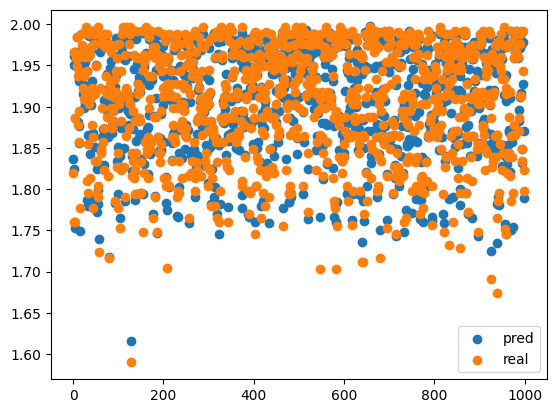

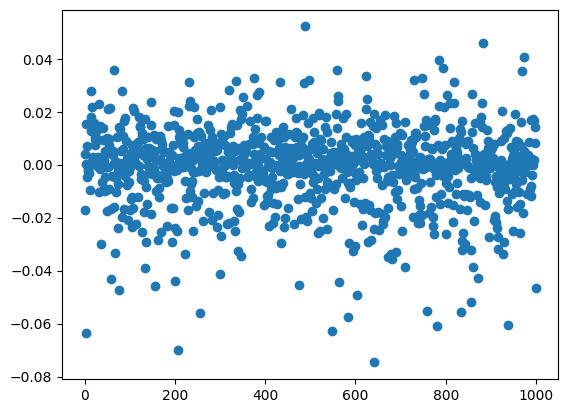

In [90]:
# Plot the results
z = np.arange(0,len(y_pred))
plt.scatter(z,y_pred,label="pred")
plt.scatter(z,y_test,label="real")
plt.legend()
plt.show()


fig = plt.figure()
e = y_test-y_pred
plt.scatter(z,e)
plt.show()

***

### Προβλέψεις μέσω Νευρωνικού !!! (exciting!)

Έχουμε ``` input_size = 4000 ```

Και ```output_size = 2```

Θα φτιάξουμε ένα απλό γραμμικό μοντέλο για εξοικείωση

Το μοντέλο θα τρέξει στην GPU αν αυτή είναι διαθέσιμη.

In [91]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


Προετοιμάζουμε τα δεδομένα όπως και προηγουμένως με το XGB μοντέλο

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(4000, 1002)
(1000, 1002)


Μετατρέπουμε όλα μας τα data σε torch tensors για να είναι συμβατά με την αρχιτεκτονική του μοντέλου και τα περνάμε στην συσκευή που χρησιμοποιούμε (CPU ή GPU).

In [93]:
# Transform the data to PyTorch tensors and move them to the GPU if available
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

Δημιουργούμε ```mini_batches``` των 32.

In [94]:
from torch.utils.data import DataLoader, TensorDataset

# Define the dataset
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Define the data loaders
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

Το μοντέλο αρχικά αποτελείται από 3 επίπεδα, με συνάρτηση ενεργοποίησης ```LeakyReLU``` η οποία μας βοηθάει να αποφύγουμε να κολλήσουμε σε μία συγκεκριμένη τιμή κατά την διάρκεια του ```training``` με αποτέλεσμα να καταστραφεί το μοντέλο.

In [95]:
from torch import nn

# Build the model

class FirstModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(FirstModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [96]:
# Define the input and output sizes
input_len = X_train_scaled.shape[1]
output_len = 1

# Instantiate the model
model_0 = FirstModel(input_size=input_len, output_size=output_len)
model_0.to(device)

FirstModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=1002, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

Αρχικοποιούμε τα βάρη καθώς παρατηρήθηκε ότι η αρχική τυχαιότητα μπορεί να καταστρέψει τα αποτελέσματα.

In [97]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        m.bias.data.zero_()  # Important to avoid big initial outputs!

model_0.apply(init_weights)


FirstModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=1002, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

Ορίζουμε την ```loss_function``` τον ```optimizer``` καθώς και τον ```learning_scheduler``` για να μειώσει τον ρυθμό εκμάθησης όσο πλησιάζουμε στην σύγκλιση.

Για ```optimizer``` δοκίμασα Adam, SGD και RMSprop, με παρόμοια αποτελέσματα.

In [98]:
# Define the loss function and the optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

Κάνουμε train το μοντέλο για 100 εποχές.

***SOS*** Για επαναληψιμότητα τρέχουμε όλα τα cells [59] - [72] με την **ΣΕΙΡΑ** αλλιώς ο optimizer αρχικοποιείται σε διαφορετικές παραμέτρους.

In [99]:
# Fit the model
torch.manual_seed(42)
epochs = 100
train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    model_0.train()
    epoch_loss = 0

    # Iterate over mini-batches
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model_0(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model_0.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        epoch_loss += loss.item()

    # Store average training loss
    train_loss_arr.append(epoch_loss / len(train_loader))

    scheduler.step(epoch_loss)
    after_lr = optimizer.param_groups[0]['lr']

    # Evaluate the model on a test set
    model_0.eval()
    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            y_test_pred = model_0(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()

    test_loss_arr.append(test_loss / len(test_loader))


    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
print(f'Epoch {epoch + 1} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')


c:\Users\georg\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\georg\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 | Loss train: 385.4625031738281 | Loss test: 0.5319424280896783 | lr = 0.01
Epoch 10 | Loss train: 0.022127230819314718 | Loss test: 0.08724729076493531 | lr = 0.01
Epoch 20 | Loss train: 0.08481273554638027 | Loss test: 0.005342118805856444 | lr = 0.001
Epoch 30 | Loss train: 0.004598605656996369 | Loss test: 0.005014326838136185 | lr = 0.001
Epoch 40 | Loss train: 0.004590731052681804 | Loss test: 0.00504385258682305 | lr = 0.001
Epoch 50 | Loss train: 0.0045637435242533685 | Loss test: 0.005020606877224054 | lr = 0.0001
Epoch 60 | Loss train: 0.004567435221746564 | Loss test: 0.005022940240451135 | lr = 0.0001
Epoch 70 | Loss train: 0.004562904814258218 | Loss test: 0.005014937079977244 | lr = 1e-05
Epoch 80 | Loss train: 0.004563544519245625 | Loss test: 0.005015920512960292 | lr = 1e-05
Epoch 90 | Loss train: 0.004562491523101926 | Loss test: 0.005015286587877199 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.0045620587076991796 | Loss test: 0.005015162059862632 |

Τι ωραία νούμερα!!! Μακάρι να αντικατοπτρίζουν την πραγματικότητα.

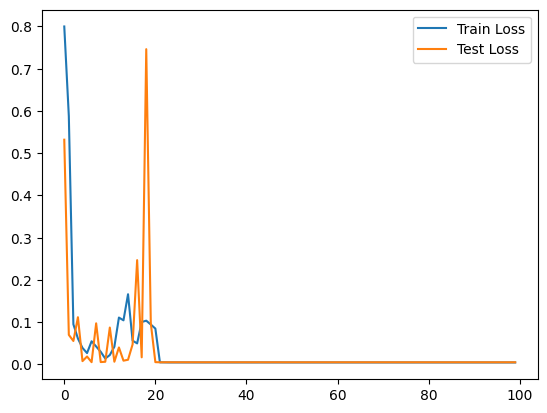

In [100]:
# Plot the loss
train_loss_arr[0] = 0.8 #Only for visualization reasons, since first training loss is a lot larger than the rest numbers
plt.plot(train_loss_arr, label='Train Loss')
plt.plot(test_loss_arr, label='Test Loss')
plt.legend()
plt.show()

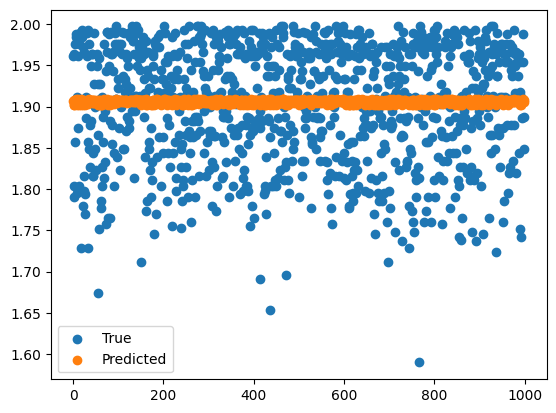

(1000, 1000)


ValueError: x and y must be the same size

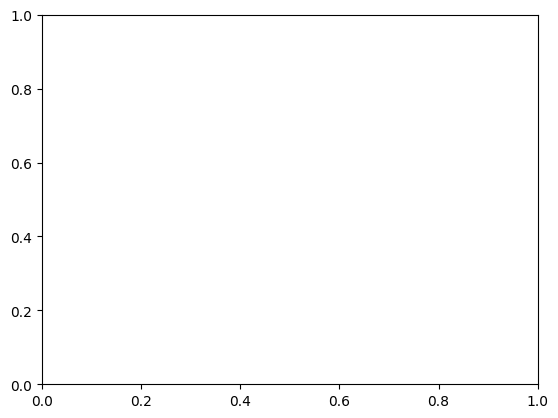

In [106]:
model_0.eval()
with torch.inference_mode():
    y_pred = model_0(X_test_tensor)

z = np.arange(0,len(y_pred))
# Plot the results
fig1 = plt.figure()
plt.scatter(z,y_test, label='True')
plt.scatter(z,y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

fig2 = plt.figure()
e = y_test-y_pred.cpu().numpy()
print(e.shape)
plt.scatter(z,e)
plt.show()

**********************